In [16]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tifffile import imread, imsave
import os
from glob import glob
from tqdm import tqdm
import sys

In [17]:
path = 'testSample/'
#os.path.exists(path)
# Load image names
flist = glob(path+'*_ill00.raw')
flist.sort()
print(flist)

['testSample/ch00_ill00.raw', 'testSample/ch01_ill00.raw', 'testSample/ch02_ill00.raw', 'testSample/ch03_ill00.raw']


In [18]:
# Load images and rescale everything to uint8
imgs=np.stack( [ np.reshape(np.frombuffer(open(i,'rb').read(),np.uint16)[:2048*2048*200],(200,2048,2048)) for i in tqdm(flist) ] )
print('Images shape: ',imgs.shape)
print('Image type: ',imgs.dtype)
print('Image memory: ',sys.getsizeof(imgs)/(1024**3))

100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


Images shape:  (4, 200, 2048, 2048)
Image type:  uint16
Image memory:  6.250000134110451


In [24]:
'''
source:
https://ianlondon.github.io/blog/how-to-sift-opencv/
'''

def gen_sift_features(gray_img):
    sift = cv2.xfeatures2d.SIFT_create()
    # kp is the keypoints
    #
    # desc is the SIFT descriptors, they're 128-dimensional vectors
    # that we can use for our final features
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

def show_sift_features(gray_img, color_img, kp, ax):
    return ax.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy(),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

# XY registration

In [25]:
mipZ=np.max(imgs,1)
for i in tqdm(list(range(mipZ.shape[0]))):
    _min=np.min(mipZ[i])
    _max=np.percentile(mipZ[i],99.7)
    mipZ[i]=np.clip(mipZ[i],_min,_max)
    mipZ[i]=(2**8-1)*((mipZ[i]-_min)/(_max-_min))
mipZ=mipZ.astype(np.uint8)
mipZ=np.moveaxis(mipZ,0,-1)

print('Max proj shape: ', mipZ.shape)
print('Max proj type: ', mipZ.dtype)
print('Max proj memory: ', sys.getsizeof(mipZ)/(1024**3))

100%|██████████| 4/4 [00:00<00:00,  9.45it/s]


Max proj shape:  (2048, 2048, 4)
Max proj type:  uint8
Max proj memory:  1.1920928955078125e-07


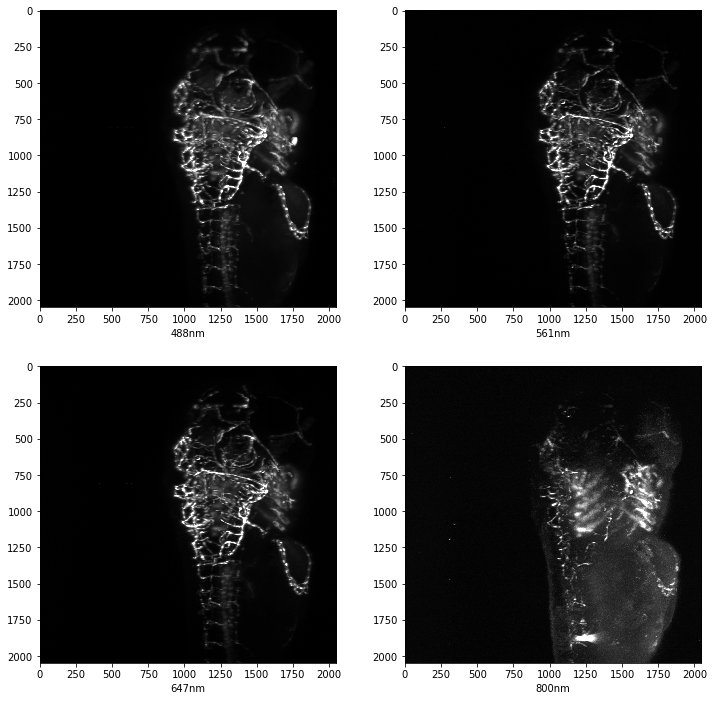

In [26]:
fig,ax=plt.subplots(figsize=(12,12),nrows=2,ncols=2)
ax=ax.flatten()

ch = ['488nm','561nm','647nm','800nm']
for i in range(mipZ.shape[-1]):
    ax[i].imshow(mipZ[...,i],cmap='gray',vmin=0,vmax=255)
    ax[i].set_xlabel(ch[i])

#from tifffile import imsave
#for i in range(4):
#    imsave('mpisOrig_%d.tif'%i,mpis[...,i])

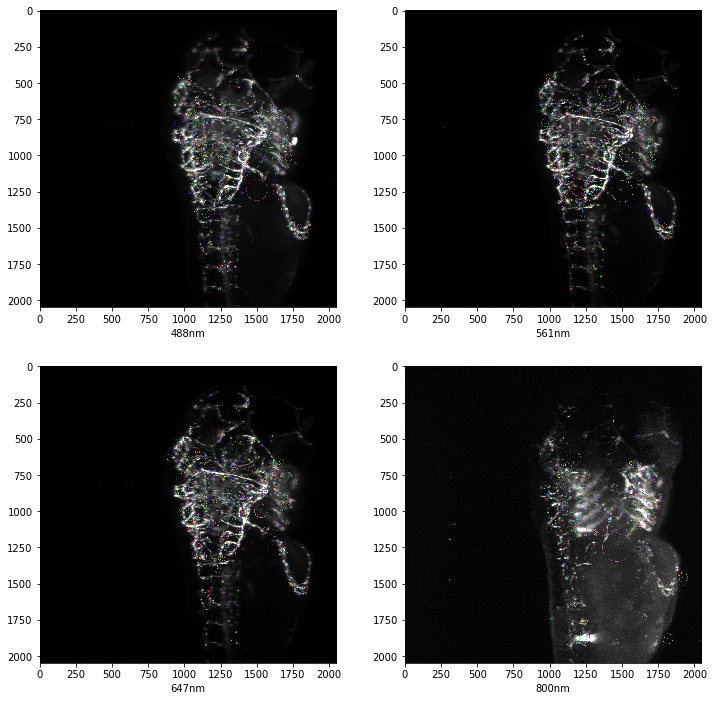

In [27]:
fig,ax=plt.subplots(figsize=(12,12),nrows=2,ncols=2)
ax=ax.flatten()
ch = ['488nm','561nm','647nm','800nm']

kp = [[],[],[],[]]
desc = [[],[],[],[]]
for i in range(mipZ.shape[-1]):
    ax[i].set_xlabel(ch[i])
    kp[i], desc[i] = gen_sift_features(mipZ[...,i])
    show_sift_features(mipZ[...,i], mipZ[...,i], kp[i], ax[i]);

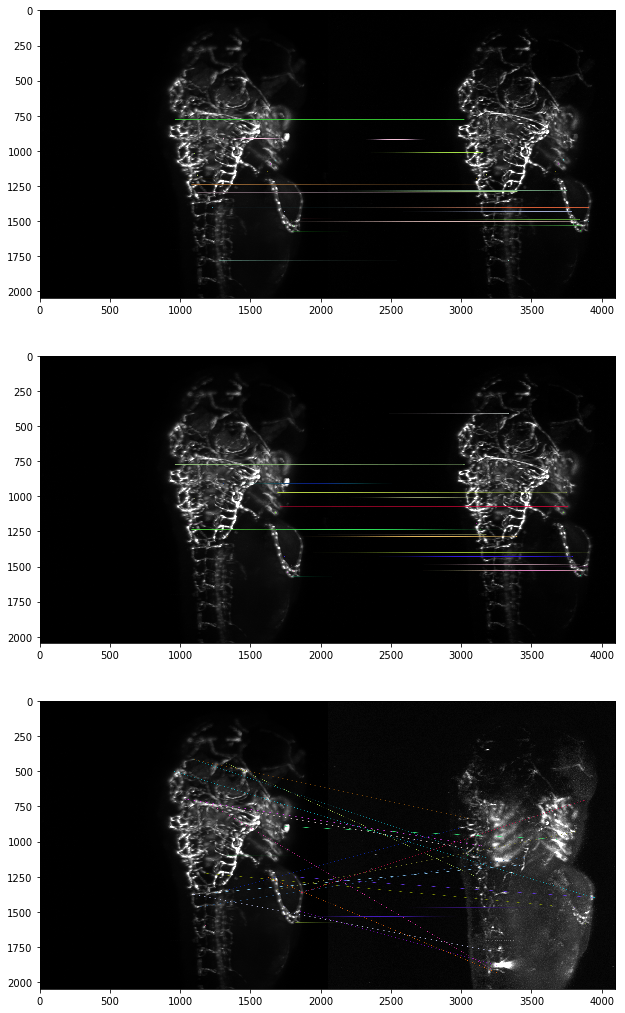

In [28]:
fig,ax=plt.subplots(figsize=(12,18),nrows=3,ncols=1)
ax=ax.flatten()
ch = ['488nm','561nm','647nm','800nm']

bf = cv2.BFMatcher(cv2.NORM_L2,crossCheck=True)

matches = [[],[],[]]
for i in range(mipZ.shape[-1]-1):
    m=bf.match(desc[0],desc[i+1])
    m=sorted(m,key=lambda x: x.distance)
    matches[i]=m[:25]
    img=cv2.drawMatches(mipZ[...,0],kp[0],mipZ[...,i+1],kp[i+1],matches[i],mipZ[...,i+1].copy(),flags=2)
    ax[i].imshow(img)

In [43]:
'''
source:
https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/
'''

h = [np.eye(3),None,None,None]
mask = [None,None,None]

for i in range(mipZ.shape[-1]-1):
    print(i,len(matches[i]),len(kp[i+1]))
    m = matches[i]
    p1 = np.zeros((len(m),2),dtype=np.float32)
    p2 = np.zeros((len(m),2),dtype=np.float32)
    print(p1.shape,p2.shape)
    for j, match in enumerate(m):
#        print(j)
        p1[j,:]=kp[0][match.queryIdx].pt
        p2[j,:]=kp[i+1][match.trainIdx].pt
    h[i+1],mask[i]=cv2.findHomography(p2,p1,cv2.RANSAC)
del mask

0 25 1086
(25, 2) (25, 2)
1 25 931
(25, 2) (25, 2)
2 25 1115
(25, 2) (25, 2)


In [44]:
mipZ_XYReg = 0*mipZ
height,width=mipZ[...,0].shape
for i in range(mipZ.shape[-1]):
    mipZ_XYReg[...,i]=cv2.warpPerspective(mipZ[...,i],h[i],(width,height))

(2048, 2048, 4) uint8


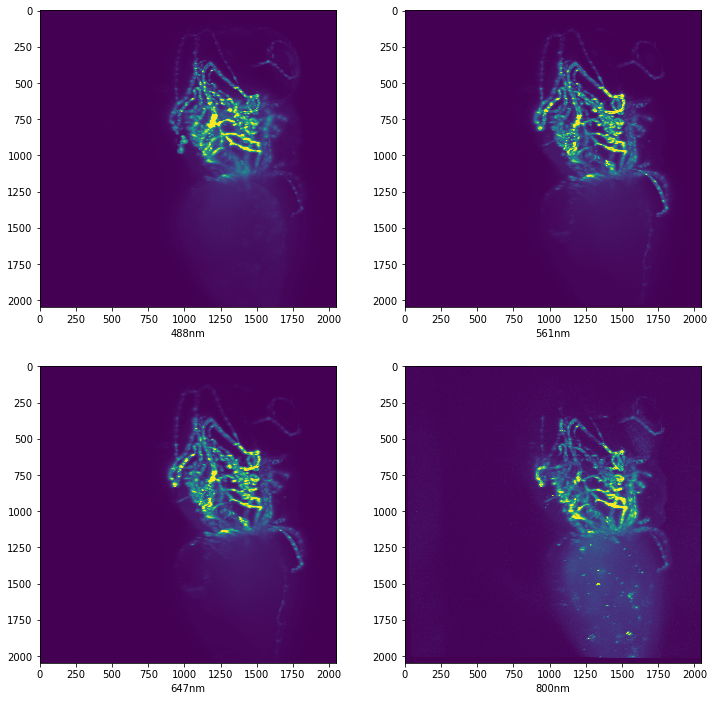

In [45]:
fig,ax=plt.subplots(figsize=(12,12),nrows=2,ncols=2)
ax=ax.flatten()
ch = ['488nm','561nm','647nm','800nm']
for i in range(mipZ_XYReg.shape[-1]):
    ax[i].imshow(mipZ_XYReg[...,i])
    ax[i].set_xlabel(ch[i])
print(mipZ_XYReg.shape,mipZ_XYReg.dtype)

In [46]:
from tifffile import imsave
for i in range(mipZ_XYReg.shape[-1]):
    imsave('mipZ_XYReg_%d.tif'%i,mipZ_XYReg[...,i])

In [47]:
imgsXYreg = 0*imgs
print(imgsXYreg.shape, imgsXYreg.dtype)

(4, 200, 2048, 2048) uint16


In [48]:
print('registering in XY...')
for i in tqdm( range(imgsXYreg.shape[1]) ):
    for j in range(mipZ_XYReg.shape[-1]):
        imgsXYreg[j,i] = cv2.warpPerspective(imgs[j,i],h[j],(width,height))


  2%|▏         | 4/200 [00:00<00:05, 37.67it/s]

registering in XY...



100%|██████████| 200/200 [00:04<00:00, 46.44it/s]

In [50]:
for i in tqdm(range(4)):
    imsave('ch%02d_ill00_XYreg.tif'%i,imgsXYreg[i])
del imgs


100%|██████████| 4/4 [00:30<00:00,  7.63s/it]


# XZ registration

In [42]:
from tifffile import imread
imgsXYreg=np.stack([imread('ch%02d_ill00_XYreg.tif'%i) for i in tqdm(list(range(imgs.shape[0])))])
print('Images shape: ',imgsXYreg.shape)
print('Image type: ',imgsXYreg.dtype)
print('Image memory: ',sys.getsizeof(imgsXYreg)/(1024**3))







  0%|          | 0/4 [00:00<?, ?it/s]





 25%|██▌       | 1/4 [00:02<00:07,  2.48s/it]





 50%|█████     | 2/4 [00:04<00:04,  2.16s/it]





 75%|███████▌  | 3/4 [00:06<00:02,  2.25s/it]





100%|██████████| 4/4 [00:08<00:00,  2.08s/it]







Images shape:  (4, 200, 2048, 2048)
Image type:  uint16
Image memory:  6.250000134110451


In [80]:
# it's too expensive to resize all images together... max projection of single stack
def resize_stack(instack):    
    _type=instack.dtype
    from skimage.transform import resize
    size=list(instack.shape)
    size[0]*=4
    return resize(instack.astype(np.float64),output_shape=size).astype(_type)

#mipY=np.stack([np.max(resize_stack(stack),2) for stack in tqdm(imgsXYreg[:2])])
mipY=np.stack([resize_stack(np.max(stack,2)) for stack in tqdm(imgsXYreg)])

print('Images shape: ',mipY.shape)
print('Image type: ',mipY.dtype)
print('Image memory: ',sys.getsizeof(mipY)/(1024**3))







  0%|          | 0/4 [00:00<?, ?it/s]/home/local/MORGRIDGE/ngritti/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "






 25%|██▌       | 1/4 [00:00<00:02,  1.47it/s]





 50%|█████     | 2/4 [00:01<00:01,  1.52it/s]





 75%|███████▌  | 3/4 [00:01<00:00,  1.51it/s]





100%|██████████| 4/4 [00:02<00:00,  1.50it/s]







Images shape:  (4, 800, 2048)
Image type:  uint16
Image memory:  0.01220715045928955


In [81]:
# make percentile clipping
for i, mip in enumerate(mipY):
    _min=np.min(mip)
    _max=np.percentile(mip,99.7)
    mip=np.clip(mip,_min,_max)
    mipY[i]=(2**8-1)*((mip-_min)/(_max-_min))
mipY=mipY.astype(np.uint8)
mipY=np.moveaxis(mipY,0,-1)

print('Max proj shape: ', mipY.shape)
print('Max proj type: ', mipY.dtype)
print('Max proj memory: ', sys.getsizeof(mipY)/(1024**3))

Max proj shape:  (800, 2048, 4)
Max proj type:  uint8
Max proj memory:  1.1920928955078125e-07


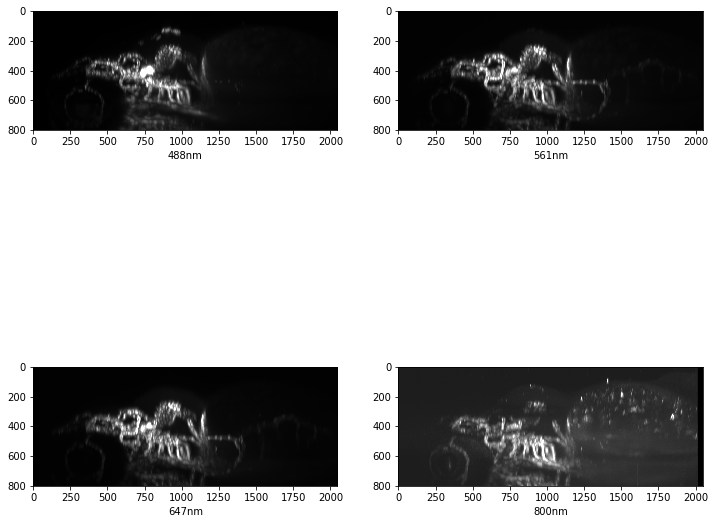

In [82]:
fig,ax=plt.subplots(figsize=(12,12),nrows=2,ncols=2)
ax=ax.flatten()

ch = ['488nm','561nm','647nm','800nm']
for i in range(mipY.shape[-1]):
    ax[i].imshow(mipY[...,i],cmap='gray',vmin=0,vmax=255)
    ax[i].set_xlabel(ch[i])

#from tifffile import imsave
#for i in range(4):
#    imsave('mpisOrig_%d.tif'%i,mpis[...,i])

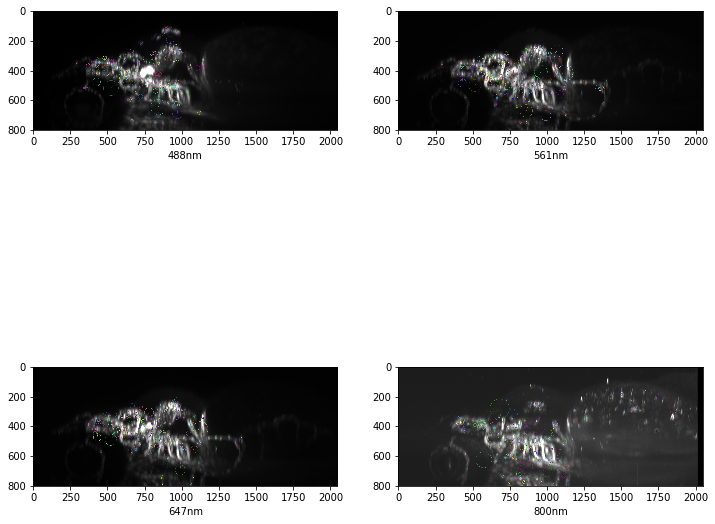

In [83]:
fig,ax=plt.subplots(figsize=(12,12),nrows=2,ncols=2)
ax=ax.flatten()
ch = ['488nm','561nm','647nm','800nm']

kp = [[],[],[],[]]
desc = [[],[],[],[]]
for i in range(mipY.shape[-1]):
    ax[i].set_xlabel(ch[i])
    kp[i], desc[i] = gen_sift_features(mipY[...,i])
    show_sift_features(mipY[...,i], mipY[...,i], kp[i], ax[i]);

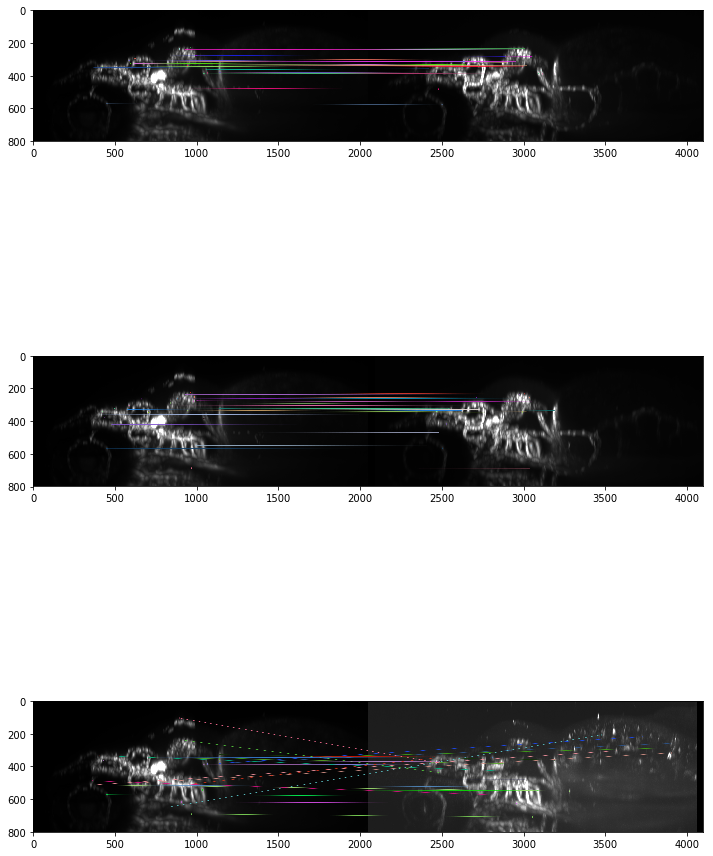

In [84]:
fig,ax=plt.subplots(figsize=(12,18),nrows=3,ncols=1)
ax=ax.flatten()
ch = ['488nm','561nm','647nm','800nm']

bf = cv2.BFMatcher(cv2.NORM_L2,crossCheck=True)

matches = [[],[],[]]
for i in range(mipY.shape[-1]-1):
    m=bf.match(desc[0],desc[i+1])
    m=sorted(m,key=lambda x: x.distance)
    matches[i]=m[:25]
    img=cv2.drawMatches(mipY[...,0],kp[0],mipY[...,i+1],kp[i+1],matches[i],mipY[...,i+1].copy(),flags=2)
    ax[i].imshow(img)

In [85]:
'''
source:
https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/
'''

h = [np.eye(3),None,None,None]
mask = [None,None,None]

for i in range(mipY.shape[-1]-1):
    print(i,len(matches[i]),len(kp[i+1]))
    m = matches[i]
    p1 = np.zeros((len(m),2),dtype=np.float32)
    p2 = np.zeros((len(m),2),dtype=np.float32)
    print(p1.shape,p2.shape)
    for j, match in enumerate(m):
#        print(j)
        p1[j,:]=kp[0][match.queryIdx].pt
        p2[j,:]=kp[i+1][match.trainIdx].pt
    h[i+1],mask[i]=cv2.findHomography(p2,p1,cv2.RANSAC)
del mask

0 25 388
(25, 2) (25, 2)
1 25 324
(25, 2) (25, 2)
2 25 365
(25, 2) (25, 2)


In [86]:
mipY_XZReg = 0*mipY
height,width=mipY[...,0].shape
for i in range(mipY.shape[-1]):
    mipY_XZReg[...,i]=cv2.warpPerspective(mipY[...,i],h[i],(width,height))

(800, 2048, 4) uint8


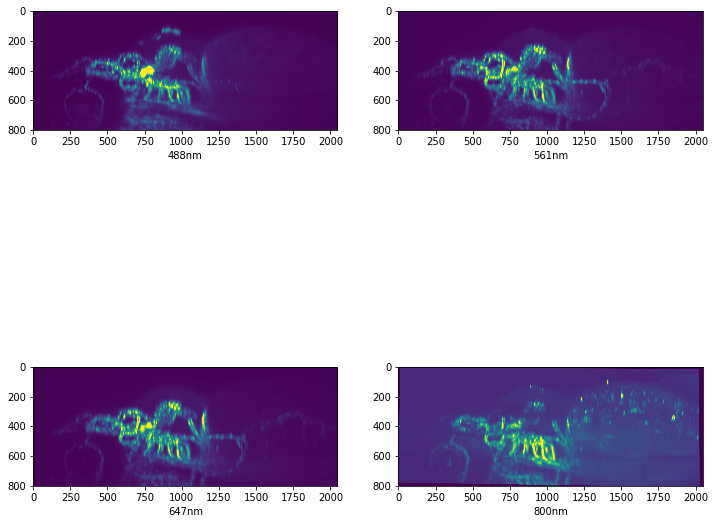

In [87]:
fig,ax=plt.subplots(figsize=(12,12),nrows=2,ncols=2)
ax=ax.flatten()
ch = ['488nm','561nm','647nm','800nm']
for i in range(mipY_XZReg.shape[-1]):
    ax[i].imshow(mipY_XZReg[...,i])
    ax[i].set_xlabel(ch[i])
print(mipY_XZReg.shape,mipY_XZReg.dtype)

In [88]:
from tifffile import imsave
for i in range(mipY_XZReg.shape[-1]):
    imsave('mip_XYZReg_%d.tif'%i,mipY_XZReg[...,i])

In [89]:
imgsXYZreg = 0*imgs
print(imgsXYZreg.shape, imgsXYZreg.dtype)

(4, 200, 2048, 2048) uint16


/home/local/MORGRIDGE/ngritti/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


4334 4300 4294
uint16
uint16


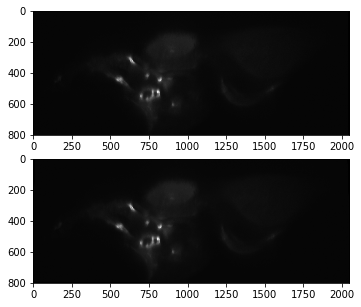

In [90]:
fig,ax=plt.subplots(figsize=(10,5),nrows=2,ncols=1)
tmp=resize_stack(imgsXYreg[1,...,1024])
tmpReg=cv2.warpPerspective(tmp,h[1],(width,height))
height,width=tmp.shape
ax[0].imshow(tmp,cmap='gray')
ax[1].imshow(tmpReg,cmap='gray')
print(np.max(imgsXYreg[1,...,1024]),np.max(tmp),np.max(tmpReg))
print(imgsXYreg.dtype)
print(tmp.dtype)

In [91]:
print('registering in XZ...')
for j in range(imgsXYZreg.shape[0]):
    for i in tqdm(list(range(imgsXYZreg.shape[-1]))):
        tmp=resize_stack(imgsXYreg[j,...,i])
        height,width=tmp.shape
#        print(width,height)
        imgsXYZreg[j,...,i] = cv2.warpPerspective(tmp,h[j],(width,height))[::4]
    imsave('ch%02d_ill00_XYZreg.tif'%j,imgsXYZreg[j])







  0%|          | 0/2048 [00:00<?, ?it/s]

registering in XZ...


/home/local/MORGRIDGE/ngritti/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "






  0%|          | 1/2048 [00:01<37:39,  1.10s/it]





  0%|          | 3/2048 [00:01<13:55,  2.45it/s]





  0%|          | 5/2048 [00:01<09:08,  3.73it/s]





  0%|          | 7/2048 [00:01<07:13,  4.71it/s]





  0%|          | 9/2048 [00:01<06:17,  5.40it/s]





  1%|          | 11/2048 [00:01<05:29,  6.18it/s]





  1%|          | 13/2048 [00:01<04:57,  6.85it/s]





  1%|          | 15/2048 [00:02<04:33,  7.44it/s]





  1%|          | 17/2048 [00:02<04:15,  7.94it/s]





  1%|          | 19/2048 [00:02<04:09,  8.13it/s]





  1%|          | 21/2048 [00:02<03:57,  8.52it/s]





  1%|          | 23/2048 [00:02<03:52,  8.70it/s]





  1%|          | 25/2048 [00:02<03:46,  8.94it/s]





  1%|▏         | 27/204

 21%|██        | 435/2048 [00:34<02:07, 12.62it/s]





 21%|██▏       | 437/2048 [00:34<02:07, 12.62it/s]





 21%|██▏       | 439/2048 [00:34<02:07, 12.61it/s]





 22%|██▏       | 441/2048 [00:34<02:07, 12.60it/s]





 22%|██▏       | 443/2048 [00:35<02:07, 12.61it/s]





 22%|██▏       | 445/2048 [00:35<02:07, 12.62it/s]





 22%|██▏       | 447/2048 [00:35<02:06, 12.63it/s]





 22%|██▏       | 449/2048 [00:35<02:06, 12.65it/s]





 22%|██▏       | 451/2048 [00:35<02:06, 12.66it/s]





 22%|██▏       | 453/2048 [00:35<02:05, 12.68it/s]





 22%|██▏       | 455/2048 [00:35<02:05, 12.69it/s]





 22%|██▏       | 457/2048 [00:36<02:05, 12.68it/s]





 22%|██▏       | 459/2048 [00:36<02:05, 12.68it/s]





 23%|██▎       | 461/2048 [00:36<02:04, 12.70it/s]





 23%|██▎       | 463/2048 [00:36<02:04, 12.70it/s]





 23%|██▎       | 465/2048 [00:36<02:04, 12.72it/s]





 23%|██▎       | 467/2048 [00:36<02:04, 12.73it/s]





 23%|██▎       | 469/2048 [00:36<02:04, 12.72it/

 43%|████▎     | 873/2048 [01:08<01:32, 12.77it/s]





 43%|████▎     | 875/2048 [01:08<01:31, 12.76it/s]





 43%|████▎     | 877/2048 [01:08<01:31, 12.74it/s]





 43%|████▎     | 879/2048 [01:08<01:31, 12.75it/s]





 43%|████▎     | 881/2048 [01:09<01:31, 12.75it/s]





 43%|████▎     | 883/2048 [01:09<01:31, 12.74it/s]





 43%|████▎     | 885/2048 [01:09<01:31, 12.74it/s]





 43%|████▎     | 887/2048 [01:09<01:31, 12.74it/s]





 43%|████▎     | 889/2048 [01:09<01:30, 12.74it/s]





 44%|████▎     | 891/2048 [01:10<01:30, 12.72it/s]





 44%|████▎     | 893/2048 [01:10<01:30, 12.72it/s]





 44%|████▎     | 895/2048 [01:10<01:30, 12.73it/s]





 44%|████▍     | 897/2048 [01:10<01:30, 12.73it/s]





 44%|████▍     | 899/2048 [01:10<01:30, 12.72it/s]





 44%|████▍     | 901/2048 [01:10<01:30, 12.72it/s]





 44%|████▍     | 903/2048 [01:10<01:30, 12.72it/s]





 44%|████▍     | 905/2048 [01:11<01:29, 12.73it/s]





 44%|████▍     | 907/2048 [01:11<01:29, 12.74it/

 64%|██████▍   | 1311/2048 [01:40<00:56, 13.06it/s]





 64%|██████▍   | 1313/2048 [01:40<00:56, 13.06it/s]





 64%|██████▍   | 1315/2048 [01:40<00:56, 13.06it/s]





 64%|██████▍   | 1317/2048 [01:40<00:55, 13.06it/s]





 64%|██████▍   | 1319/2048 [01:40<00:55, 13.07it/s]





 65%|██████▍   | 1321/2048 [01:41<00:55, 13.07it/s]





 65%|██████▍   | 1323/2048 [01:41<00:55, 13.08it/s]





 65%|██████▍   | 1325/2048 [01:41<00:55, 13.08it/s]





 65%|██████▍   | 1327/2048 [01:41<00:55, 13.08it/s]





 65%|██████▍   | 1329/2048 [01:41<00:54, 13.08it/s]





 65%|██████▍   | 1331/2048 [01:41<00:54, 13.09it/s]





 65%|██████▌   | 1333/2048 [01:41<00:54, 13.09it/s]





 65%|██████▌   | 1335/2048 [01:41<00:54, 13.09it/s]





 65%|██████▌   | 1337/2048 [01:42<00:54, 13.10it/s]





 65%|██████▌   | 1339/2048 [01:42<00:54, 13.10it/s]





 65%|██████▌   | 1341/2048 [01:42<00:53, 13.11it/s]





 66%|██████▌   | 1343/2048 [01:42<00:53, 13.11it/s]





 66%|██████▌   | 1345/2048 [01:

 85%|████████▌ | 1747/2048 [02:11<00:22, 13.24it/s]





 85%|████████▌ | 1749/2048 [02:12<00:22, 13.23it/s]





 85%|████████▌ | 1751/2048 [02:12<00:22, 13.24it/s]





 86%|████████▌ | 1753/2048 [02:12<00:22, 13.24it/s]





 86%|████████▌ | 1755/2048 [02:12<00:22, 13.24it/s]





 86%|████████▌ | 1757/2048 [02:12<00:21, 13.24it/s]





 86%|████████▌ | 1759/2048 [02:12<00:21, 13.24it/s]





 86%|████████▌ | 1761/2048 [02:12<00:21, 13.24it/s]





 86%|████████▌ | 1763/2048 [02:13<00:21, 13.25it/s]





 86%|████████▌ | 1765/2048 [02:13<00:21, 13.25it/s]





 86%|████████▋ | 1767/2048 [02:13<00:21, 13.25it/s]





 86%|████████▋ | 1769/2048 [02:13<00:21, 13.24it/s]





 86%|████████▋ | 1771/2048 [02:13<00:20, 13.24it/s]





 87%|████████▋ | 1773/2048 [02:14<00:20, 13.22it/s]





 87%|████████▋ | 1775/2048 [02:14<00:20, 13.22it/s]





 87%|████████▋ | 1777/2048 [02:14<00:20, 13.23it/s]





 87%|████████▋ | 1779/2048 [02:14<00:20, 13.22it/s]





 87%|████████▋ | 1781/2048 [02:

  7%|▋         | 135/2048 [00:10<02:22, 13.42it/s]





  7%|▋         | 137/2048 [00:10<02:23, 13.30it/s]





  7%|▋         | 139/2048 [00:10<02:23, 13.29it/s]





  7%|▋         | 141/2048 [00:10<02:23, 13.33it/s]





  7%|▋         | 143/2048 [00:10<02:24, 13.22it/s]





  7%|▋         | 145/2048 [00:10<02:23, 13.24it/s]





  7%|▋         | 147/2048 [00:11<02:23, 13.27it/s]





  7%|▋         | 149/2048 [00:11<02:22, 13.29it/s]





  7%|▋         | 151/2048 [00:11<02:23, 13.24it/s]





  7%|▋         | 153/2048 [00:11<02:22, 13.29it/s]





  8%|▊         | 155/2048 [00:11<02:21, 13.33it/s]





  8%|▊         | 157/2048 [00:11<02:22, 13.31it/s]





  8%|▊         | 159/2048 [00:11<02:22, 13.30it/s]





  8%|▊         | 161/2048 [00:12<02:21, 13.34it/s]





  8%|▊         | 163/2048 [00:12<02:20, 13.39it/s]





  8%|▊         | 165/2048 [00:12<02:21, 13.31it/s]





  8%|▊         | 167/2048 [00:12<02:21, 13.31it/s]





  8%|▊         | 169/2048 [00:12<02:21, 13.32it/

 28%|██▊       | 574/2048 [00:43<01:50, 13.30it/s]





 28%|██▊       | 576/2048 [00:43<01:50, 13.29it/s]





 28%|██▊       | 578/2048 [00:43<01:50, 13.29it/s]





 28%|██▊       | 580/2048 [00:43<01:50, 13.30it/s]





 28%|██▊       | 582/2048 [00:43<01:50, 13.30it/s]





 29%|██▊       | 584/2048 [00:43<01:50, 13.29it/s]





 29%|██▊       | 586/2048 [00:44<01:49, 13.30it/s]





 29%|██▊       | 588/2048 [00:44<01:49, 13.31it/s]





 29%|██▉       | 590/2048 [00:44<01:49, 13.31it/s]





 29%|██▉       | 592/2048 [00:44<01:49, 13.32it/s]





 29%|██▉       | 594/2048 [00:44<01:49, 13.31it/s]





 29%|██▉       | 596/2048 [00:44<01:49, 13.29it/s]





 29%|██▉       | 598/2048 [00:44<01:49, 13.29it/s]





 29%|██▉       | 600/2048 [00:45<01:49, 13.27it/s]





 29%|██▉       | 602/2048 [00:45<01:49, 13.26it/s]





 29%|██▉       | 604/2048 [00:45<01:49, 13.25it/s]





 30%|██▉       | 606/2048 [00:45<01:48, 13.24it/s]





 30%|██▉       | 608/2048 [00:45<01:48, 13.22it/

 50%|████▉     | 1014/2048 [01:16<01:18, 13.18it/s]





 50%|████▉     | 1016/2048 [01:17<01:18, 13.18it/s]





 50%|████▉     | 1018/2048 [01:17<01:18, 13.18it/s]





 50%|████▉     | 1020/2048 [01:17<01:18, 13.18it/s]





 50%|████▉     | 1022/2048 [01:17<01:17, 13.18it/s]





 50%|█████     | 1024/2048 [01:17<01:17, 13.18it/s]





 50%|█████     | 1026/2048 [01:17<01:17, 13.18it/s]





 50%|█████     | 1028/2048 [01:18<01:17, 13.17it/s]





 50%|█████     | 1030/2048 [01:18<01:17, 13.15it/s]





 50%|█████     | 1032/2048 [01:18<01:17, 13.14it/s]





 50%|█████     | 1034/2048 [01:18<01:17, 13.12it/s]





 51%|█████     | 1036/2048 [01:18<01:17, 13.13it/s]





 51%|█████     | 1038/2048 [01:19<01:16, 13.14it/s]





 51%|█████     | 1040/2048 [01:19<01:16, 13.14it/s]





 51%|█████     | 1042/2048 [01:19<01:16, 13.14it/s]





 51%|█████     | 1044/2048 [01:19<01:16, 13.14it/s]





 51%|█████     | 1046/2048 [01:19<01:16, 13.15it/s]





 51%|█████     | 1048/2048 [01:

 71%|███████   | 1449/2048 [01:49<00:45, 13.21it/s]





 71%|███████   | 1451/2048 [01:49<00:45, 13.21it/s]





 71%|███████   | 1453/2048 [01:49<00:45, 13.21it/s]





 71%|███████   | 1455/2048 [01:50<00:44, 13.21it/s]





 71%|███████   | 1457/2048 [01:50<00:44, 13.22it/s]





 71%|███████   | 1459/2048 [01:50<00:44, 13.22it/s]





 71%|███████▏  | 1461/2048 [01:50<00:44, 13.22it/s]





 71%|███████▏  | 1463/2048 [01:50<00:44, 13.23it/s]





 72%|███████▏  | 1465/2048 [01:50<00:44, 13.23it/s]





 72%|███████▏  | 1467/2048 [01:50<00:43, 13.22it/s]





 72%|███████▏  | 1469/2048 [01:51<00:43, 13.23it/s]





 72%|███████▏  | 1471/2048 [01:51<00:43, 13.23it/s]





 72%|███████▏  | 1473/2048 [01:51<00:43, 13.23it/s]





 72%|███████▏  | 1475/2048 [01:51<00:43, 13.23it/s]





 72%|███████▏  | 1477/2048 [01:51<00:43, 13.22it/s]





 72%|███████▏  | 1479/2048 [01:51<00:43, 13.21it/s]





 72%|███████▏  | 1481/2048 [01:52<00:42, 13.21it/s]





 72%|███████▏  | 1483/2048 [01:

 92%|█████████▏| 1885/2048 [02:22<00:12, 13.24it/s]





 92%|█████████▏| 1887/2048 [02:22<00:12, 13.24it/s]





 92%|█████████▏| 1889/2048 [02:22<00:12, 13.23it/s]





 92%|█████████▏| 1891/2048 [02:22<00:11, 13.24it/s]





 92%|█████████▏| 1893/2048 [02:22<00:11, 13.24it/s]





 93%|█████████▎| 1895/2048 [02:23<00:11, 13.24it/s]





 93%|█████████▎| 1897/2048 [02:23<00:11, 13.24it/s]





 93%|█████████▎| 1899/2048 [02:23<00:11, 13.24it/s]





 93%|█████████▎| 1901/2048 [02:23<00:11, 13.24it/s]





 93%|█████████▎| 1903/2048 [02:23<00:10, 13.25it/s]





 93%|█████████▎| 1905/2048 [02:23<00:10, 13.25it/s]





 93%|█████████▎| 1907/2048 [02:23<00:10, 13.25it/s]





 93%|█████████▎| 1909/2048 [02:24<00:10, 13.24it/s]





 93%|█████████▎| 1911/2048 [02:24<00:10, 13.24it/s]





 93%|█████████▎| 1913/2048 [02:24<00:10, 13.23it/s]





 94%|█████████▎| 1915/2048 [02:24<00:10, 13.23it/s]





 94%|█████████▎| 1917/2048 [02:24<00:09, 13.24it/s]





 94%|█████████▎| 1919/2048 [02:

 13%|█▎        | 275/2048 [00:21<02:16, 12.96it/s]





 14%|█▎        | 277/2048 [00:21<02:16, 12.97it/s]





 14%|█▎        | 279/2048 [00:21<02:16, 12.98it/s]





 14%|█▎        | 281/2048 [00:21<02:15, 13.01it/s]





 14%|█▍        | 283/2048 [00:21<02:15, 13.01it/s]





 14%|█▍        | 285/2048 [00:21<02:15, 13.01it/s]





 14%|█▍        | 287/2048 [00:22<02:15, 13.04it/s]





 14%|█▍        | 289/2048 [00:22<02:14, 13.06it/s]





 14%|█▍        | 291/2048 [00:22<02:14, 13.08it/s]





 14%|█▍        | 293/2048 [00:22<02:14, 13.08it/s]





 14%|█▍        | 295/2048 [00:22<02:14, 13.06it/s]





 15%|█▍        | 297/2048 [00:22<02:14, 13.05it/s]





 15%|█▍        | 299/2048 [00:22<02:14, 13.05it/s]





 15%|█▍        | 301/2048 [00:23<02:13, 13.07it/s]





 15%|█▍        | 303/2048 [00:23<02:13, 13.09it/s]





 15%|█▍        | 305/2048 [00:23<02:13, 13.08it/s]





 15%|█▍        | 307/2048 [00:23<02:13, 13.09it/s]





 15%|█▌        | 309/2048 [00:23<02:12, 13.08it/

 35%|███▍      | 715/2048 [00:54<01:41, 13.15it/s]





 35%|███▌      | 717/2048 [00:54<01:41, 13.15it/s]





 35%|███▌      | 719/2048 [00:54<01:40, 13.16it/s]





 35%|███▌      | 721/2048 [00:54<01:40, 13.17it/s]





 35%|███▌      | 723/2048 [00:54<01:40, 13.17it/s]





 35%|███▌      | 725/2048 [00:55<01:40, 13.18it/s]





 35%|███▌      | 727/2048 [00:55<01:40, 13.18it/s]





 36%|███▌      | 729/2048 [00:55<01:40, 13.18it/s]





 36%|███▌      | 731/2048 [00:55<01:40, 13.15it/s]





 36%|███▌      | 733/2048 [00:55<01:39, 13.16it/s]





 36%|███▌      | 735/2048 [00:55<01:39, 13.17it/s]





 36%|███▌      | 737/2048 [00:55<01:39, 13.18it/s]





 36%|███▌      | 739/2048 [00:56<01:39, 13.19it/s]





 36%|███▌      | 741/2048 [00:56<01:39, 13.20it/s]





 36%|███▋      | 743/2048 [00:56<01:38, 13.21it/s]





 36%|███▋      | 745/2048 [00:56<01:38, 13.18it/s]





 36%|███▋      | 747/2048 [00:56<01:38, 13.15it/s]





 37%|███▋      | 749/2048 [00:56<01:38, 13.16it/

 56%|█████▌    | 1150/2048 [01:28<01:08, 13.07it/s]





 56%|█████▋    | 1152/2048 [01:28<01:08, 13.07it/s]





 56%|█████▋    | 1154/2048 [01:28<01:08, 13.08it/s]





 56%|█████▋    | 1156/2048 [01:28<01:08, 13.08it/s]





 57%|█████▋    | 1158/2048 [01:28<01:08, 13.09it/s]





 57%|█████▋    | 1160/2048 [01:28<01:07, 13.09it/s]





 57%|█████▋    | 1162/2048 [01:28<01:07, 13.10it/s]





 57%|█████▋    | 1164/2048 [01:28<01:07, 13.10it/s]





 57%|█████▋    | 1166/2048 [01:29<01:07, 13.10it/s]





 57%|█████▋    | 1168/2048 [01:29<01:07, 13.09it/s]





 57%|█████▋    | 1170/2048 [01:29<01:07, 13.08it/s]





 57%|█████▋    | 1172/2048 [01:29<01:06, 13.08it/s]





 57%|█████▋    | 1174/2048 [01:29<01:06, 13.07it/s]





 57%|█████▋    | 1176/2048 [01:30<01:06, 13.06it/s]





 58%|█████▊    | 1178/2048 [01:30<01:06, 13.06it/s]





 58%|█████▊    | 1180/2048 [01:30<01:06, 13.07it/s]





 58%|█████▊    | 1182/2048 [01:30<01:06, 13.07it/s]





 58%|█████▊    | 1184/2048 [01:

 77%|███████▋  | 1586/2048 [02:00<00:35, 13.17it/s]





 78%|███████▊  | 1588/2048 [02:00<00:34, 13.16it/s]





 78%|███████▊  | 1590/2048 [02:00<00:34, 13.16it/s]





 78%|███████▊  | 1592/2048 [02:01<00:34, 13.16it/s]





 78%|███████▊  | 1594/2048 [02:01<00:34, 13.16it/s]





 78%|███████▊  | 1596/2048 [02:01<00:34, 13.17it/s]





 78%|███████▊  | 1598/2048 [02:01<00:34, 13.17it/s]





 78%|███████▊  | 1600/2048 [02:01<00:34, 13.18it/s]





 78%|███████▊  | 1602/2048 [02:01<00:33, 13.18it/s]





 78%|███████▊  | 1604/2048 [02:01<00:33, 13.17it/s]





 78%|███████▊  | 1606/2048 [02:01<00:33, 13.18it/s]





 79%|███████▊  | 1608/2048 [02:02<00:33, 13.18it/s]





 79%|███████▊  | 1610/2048 [02:02<00:33, 13.18it/s]





 79%|███████▊  | 1612/2048 [02:02<00:33, 13.18it/s]





 79%|███████▉  | 1614/2048 [02:02<00:32, 13.17it/s]





 79%|███████▉  | 1616/2048 [02:02<00:32, 13.17it/s]





 79%|███████▉  | 1618/2048 [02:02<00:32, 13.17it/s]





 79%|███████▉  | 1620/2048 [02:

 99%|█████████▊| 2022/2048 [02:31<00:01, 13.32it/s]





 99%|█████████▉| 2024/2048 [02:31<00:01, 13.33it/s]





 99%|█████████▉| 2026/2048 [02:31<00:01, 13.33it/s]





 99%|█████████▉| 2028/2048 [02:32<00:01, 13.32it/s]





 99%|█████████▉| 2030/2048 [02:32<00:01, 13.33it/s]





 99%|█████████▉| 2032/2048 [02:32<00:01, 13.32it/s]





 99%|█████████▉| 2034/2048 [02:32<00:01, 13.32it/s]





 99%|█████████▉| 2036/2048 [02:32<00:00, 13.32it/s]





100%|█████████▉| 2038/2048 [02:33<00:00, 13.31it/s]





100%|█████████▉| 2040/2048 [02:33<00:00, 13.32it/s]





100%|█████████▉| 2042/2048 [02:33<00:00, 13.32it/s]





100%|█████████▉| 2044/2048 [02:33<00:00, 13.32it/s]





100%|█████████▉| 2046/2048 [02:33<00:00, 13.33it/s]





100%|██████████| 2048/2048 [02:33<00:00, 13.32it/s]











  0%|          | 0/2048 [00:00<?, ?it/s]





  0%|          | 1/2048 [00:00<29:16,  1.17it/s]





  0%|          | 3/2048 [00:00<11:04,  3.08it/s]





  0%|          | 5/2048 [00:01<07:34,  4.5

 20%|█▉        | 404/2048 [00:32<02:12, 12.37it/s]





 20%|█▉        | 406/2048 [00:32<02:12, 12.37it/s]





 20%|█▉        | 408/2048 [00:33<02:12, 12.36it/s]





 20%|██        | 410/2048 [00:33<02:12, 12.32it/s]





 20%|██        | 412/2048 [00:33<02:12, 12.32it/s]





 20%|██        | 414/2048 [00:33<02:12, 12.31it/s]





 20%|██        | 416/2048 [00:33<02:12, 12.33it/s]





 20%|██        | 418/2048 [00:33<02:12, 12.33it/s]





 21%|██        | 420/2048 [00:34<02:11, 12.34it/s]





 21%|██        | 422/2048 [00:34<02:11, 12.35it/s]





 21%|██        | 424/2048 [00:34<02:11, 12.37it/s]





 21%|██        | 426/2048 [00:34<02:10, 12.39it/s]





 21%|██        | 428/2048 [00:34<02:10, 12.41it/s]





 21%|██        | 430/2048 [00:34<02:10, 12.40it/s]





 21%|██        | 432/2048 [00:34<02:10, 12.41it/s]





 21%|██        | 434/2048 [00:34<02:10, 12.41it/s]





 21%|██▏       | 436/2048 [00:35<02:09, 12.42it/s]





 21%|██▏       | 438/2048 [00:35<02:09, 12.43it/

 41%|████      | 840/2048 [01:05<01:34, 12.85it/s]





 41%|████      | 842/2048 [01:05<01:33, 12.86it/s]





 41%|████      | 844/2048 [01:05<01:33, 12.86it/s]





 41%|████▏     | 846/2048 [01:05<01:33, 12.86it/s]





 41%|████▏     | 848/2048 [01:05<01:33, 12.86it/s]





 42%|████▏     | 850/2048 [01:06<01:33, 12.85it/s]





 42%|████▏     | 852/2048 [01:06<01:33, 12.85it/s]





 42%|████▏     | 854/2048 [01:06<01:32, 12.85it/s]





 42%|████▏     | 856/2048 [01:06<01:32, 12.85it/s]





 42%|████▏     | 858/2048 [01:06<01:32, 12.86it/s]





 42%|████▏     | 860/2048 [01:06<01:32, 12.87it/s]





 42%|████▏     | 862/2048 [01:06<01:32, 12.87it/s]





 42%|████▏     | 864/2048 [01:07<01:32, 12.87it/s]





 42%|████▏     | 866/2048 [01:07<01:31, 12.86it/s]





 42%|████▏     | 868/2048 [01:07<01:31, 12.87it/s]





 42%|████▏     | 870/2048 [01:07<01:31, 12.87it/s]





 43%|████▎     | 872/2048 [01:07<01:31, 12.87it/s]





 43%|████▎     | 874/2048 [01:07<01:31, 12.88it/

 62%|██████▏   | 1275/2048 [01:38<00:59, 12.96it/s]





 62%|██████▏   | 1277/2048 [01:38<00:59, 12.96it/s]





 62%|██████▏   | 1279/2048 [01:38<00:59, 12.96it/s]





 63%|██████▎   | 1281/2048 [01:38<00:59, 12.97it/s]





 63%|██████▎   | 1283/2048 [01:38<00:58, 12.97it/s]





 63%|██████▎   | 1285/2048 [01:39<00:58, 12.98it/s]





 63%|██████▎   | 1287/2048 [01:39<00:58, 12.98it/s]





 63%|██████▎   | 1289/2048 [01:39<00:58, 12.99it/s]





 63%|██████▎   | 1291/2048 [01:39<00:58, 12.99it/s]





 63%|██████▎   | 1293/2048 [01:39<00:58, 12.99it/s]





 63%|██████▎   | 1295/2048 [01:39<00:57, 12.99it/s]





 63%|██████▎   | 1297/2048 [01:39<00:57, 12.99it/s]





 63%|██████▎   | 1299/2048 [01:39<00:57, 13.00it/s]





 64%|██████▎   | 1301/2048 [01:40<00:57, 13.00it/s]





 64%|██████▎   | 1303/2048 [01:40<00:57, 13.01it/s]





 64%|██████▎   | 1305/2048 [01:40<00:57, 13.01it/s]





 64%|██████▍   | 1307/2048 [01:40<00:56, 13.01it/s]





 64%|██████▍   | 1309/2048 [01:

 84%|████████▎ | 1713/2048 [02:09<00:25, 13.22it/s]





 84%|████████▎ | 1715/2048 [02:09<00:25, 13.22it/s]





 84%|████████▍ | 1717/2048 [02:09<00:25, 13.22it/s]





 84%|████████▍ | 1719/2048 [02:10<00:24, 13.21it/s]





 84%|████████▍ | 1721/2048 [02:10<00:24, 13.22it/s]





 84%|████████▍ | 1723/2048 [02:10<00:24, 13.22it/s]





 84%|████████▍ | 1725/2048 [02:10<00:24, 13.22it/s]





 84%|████████▍ | 1727/2048 [02:10<00:24, 13.23it/s]





 84%|████████▍ | 1729/2048 [02:10<00:24, 13.23it/s]





 85%|████████▍ | 1731/2048 [02:10<00:23, 13.23it/s]





 85%|████████▍ | 1733/2048 [02:11<00:23, 13.23it/s]





 85%|████████▍ | 1735/2048 [02:11<00:23, 13.23it/s]





 85%|████████▍ | 1737/2048 [02:11<00:23, 13.23it/s]





 85%|████████▍ | 1739/2048 [02:11<00:23, 13.23it/s]





 85%|████████▌ | 1741/2048 [02:11<00:23, 13.23it/s]





 85%|████████▌ | 1743/2048 [02:11<00:23, 13.24it/s]





 85%|████████▌ | 1745/2048 [02:11<00:22, 13.24it/s]





 85%|████████▌ | 1748/2048 [02:

In [26]:
for i in tqdm(range(4)):
    imsave('ch%02d_ill00_XYZreg.tif'%i,imgsXYZreg[i])
#del imgs




  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:07<00:21,  7.12s/it]


 50%|█████     | 2/4 [00:14<00:14,  7.04s/it]


 75%|███████▌  | 3/4 [00:21<00:07,  7.17s/it]


100%|██████████| 4/4 [00:29<00:00,  7.40s/it]




In [34]:
h[0]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])





 50%|████▉     | 1015/2048 [01:24<01:25, 12.08it/s]